# Fitting Gaussian Process Models in Python

## Building models with Gaussians

In [1]:
import numpy as np
import matplotlib.pyplot as plt

A Gaussian Process (GP) is fully specified by a mean function and a covariance function.

$$ p(x) \sim \mathcal{GP}(m(x), k(x,x')) $$

One possible specification is:

$$ 
\begin{align*} 
    m(x) &= 0 \\
    k(x, x') &= \theta_1\exp{\left(-\frac{\theta_2}{2}(x-x')^2\right)}
\end{align*} 
$$

In [2]:
def exponential_cov(x, y, params):
    return params[0] * np.exp(-0.5 * params[1] * np.power(np.subtract.outer(x,y), 2))

Using the conditional property of multivariate Gaussian distributions, we can generate realizations sequentially, point by point.

$$ p(x|y) = \mathcal{N}(\mu_x + \Sigma_{xy}\Sigma_y^{-1}(y-\mu_y),
\Sigma_x-\Sigma{xy}\Sigma_y^{-1}\Sigma{xy}^T) $$

In [3]:
def conditional(x_new, x, y, params):
    B = exponential_cov(x_new, x, params)
    C = exponential_cov(x, x, params)
    A = exponential_cov(x_new, x_new, params)
    mu = np.linalg.inv(C).dot(B.T).T.dot(y)
    sigma = A - B.dot(np.linalg.inv(C).dot(B.T))
    return mu.squeeze(), sigma.squeeze()

Start with a GP prior with hyperparameters $\sigma_0=1,\sigma_1=10.$

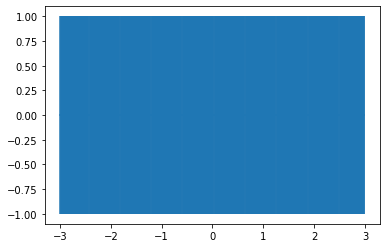

In [4]:
theta = [1, 10]
sigma_0 = exponential_cov(0, 0, theta)
xpts = np.arange(-3, 3, step=0.01)
plt.errorbar(xpts, np.zeros(len(xpts)), yerr=sigma_0, capsize=0)
plt.show()

Select an arbitrary starting point to sample, say $x=1$. With no previous points, we can sample from an unconditional Gaussian.

In [5]:
x = [1.]
y = [np.random.normal(scale=sigma_0)]
print(y)

[2.0089810532585686]


We can now update our confidence band, given the point that we just sampled, using the covariance function to generate new point-wise intervals, conditional on the value $(x_0, y_0)$.

In [6]:
def predict(x, data, kernel, params, sigma, t):
    k = [kernel(x, y, params) for y in data]
    Sinv = np.linalg.inv(sigma)
    y_pred = np.dot(k, Sinv).dot(t)
    sigma_new = kernel(x, y, params) - np.dot(k, Sinv).dot(k)
    return y_pred, sigma_new.item()

sigma_1 = exponential_cov(x, x, theta)
x_pred = np.linspace(-3, 3, 1000)
predictions = [predict(i, x, exponential_cov, theta, sigma_1, y) for i in x_pred]

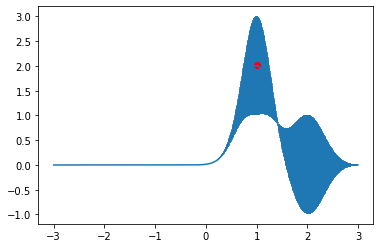

In [7]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, 'ro')
plt.show()

Sample another point.

In [8]:
m, s = conditional([-0.7], x, y, theta)
y2 = np.random.normal(m, s)
print(y2)

-0.9689310539862385


Add the point to the realization and update the location for the next point.

In [9]:
x.append(-0.7)
y.append(y2)
sigma_2 = exponential_cov(x, x, theta)
predictions = [predict(i, x, exponential_cov, theta, sigma_2, y) for i in x_pred]

ValueError: can only convert an array of size 1 to a Python scalar

In [ ]:
y_pred, sigmas = np.transpose(predictions)
plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
plt.plot(x, y, 'ro')
plt.show()